<a href="https://colab.research.google.com/github/ShrutiAggarwal99/udacity-deep-learning-with-pytorch/blob/master/L5_Part_8_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning 

> Using pre-trained networks to solve our problem

> These models are pre-trained on some large dataset (like ImageNet) and work astonishingly well as feature-detectors, even for images that they are not trained on.

> Using a pre-trained network on images not in the training set is called transfer learning. 

> Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

**These models can be used from** `torchvision.models`

In [1]:
# Downloading the data

!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip

--2019-12-29 17:26:29--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.98.13
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.98.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  28.2MB/s    in 21s     

2019-12-29 17:26:50 (26.9 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [0]:
!unzip Cat_Dog_data.zip

In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torchvision import models

In [0]:
# Loading the data using torchvision

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor()])

train_dataset = datasets.ImageFolder('Cat_Dog_data/train', transform=train_transform)
test_dataset = datasets.ImageFolder('Cat_Dog_data/test', transform=test_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [5]:
images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


**Now we use a pre-trained model**

In [22]:
# usings torchvision.models to load pre-trained models
from torchvision import models

# pre-trained model
model = models.densenet121(pretrained=True)
model

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Defining the new classifier
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 256)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(256, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Changing the classifier of pretrained model
model.classifier = classifier

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [23]:
# Training the new classifier

epochs = 1

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr = 0.003)

train_loss = []
test_loss = []

steps = 0
print_every = 5

for e in range(epochs):

  running_train_loss = 0
  model.train()

  for images,labels in trainloader:

    steps += 1

    images, labels = images.to(device), labels.to(device)

    log_ps = model(images)
    loss = criterion(log_ps, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_train_loss += loss.item()

    # For every 5 batches in trainloader, perform validation
    if steps % print_every == 0:

      model.eval()

      with torch.no_grad():

        batch_test_loss = 0
        accuracy = 0

        for images,labels in testloader:

          images, labels = images.to(device), labels.to(device)

          log_ps = model(images)
          batch_test_loss += criterion(log_ps, labels).item()

          ps = torch.exp(log_ps)
          top_p, top_class = ps.topk(k=1, dim=1)
          equality = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equality.type(torch.FloatTensor))
          
      model.train()

      train_loss.append(running_train_loss)
      test_loss.append(running_test_loss)
      print("Epoch: ", e+1,
            "Training Loss: ", running_train_loss/print_every,
            "Test Loss: ", batch_test_loss/len(testloader),
            "Test Accuracy: ", accuracy/len(testloader))

Epoch:  1 Training Loss:  0.8631728947162628 Test Loss:  0.29644215665757656 Test Accuracy:  tensor(0.9492)
Epoch:  1 Training Loss:  1.178601023554802 Test Loss:  0.14616333320736885 Test Accuracy:  tensor(0.9613)
Epoch:  1 Training Loss:  1.4256123185157776 Test Loss:  0.11414425279945135 Test Accuracy:  tensor(0.9559)
Epoch:  1 Training Loss:  1.6863593459129333 Test Loss:  0.07071987614035606 Test Accuracy:  tensor(0.9742)
Epoch:  1 Training Loss:  1.8742607846856116 Test Loss:  0.06263657030649483 Test Accuracy:  tensor(0.9777)
Epoch:  1 Training Loss:  2.0741627722978593 Test Loss:  0.053202201053500174 Test Accuracy:  tensor(0.9820)
Epoch:  1 Training Loss:  2.2687877506017684 Test Loss:  0.052485018596053125 Test Accuracy:  tensor(0.9816)
Epoch:  1 Training Loss:  2.495473951101303 Test Loss:  0.09639704069122672 Test Accuracy:  tensor(0.9641)
Epoch:  1 Training Loss:  2.7728597790002825 Test Loss:  0.14153455542400478 Test Accuracy:  tensor(0.9438)
Epoch:  1 Training Loss:  2.

KeyboardInterrupt: ignored

Label:  tensor(1, device='cuda:0')
Predicted CLass:  tensor([[1]], device='cuda:0')


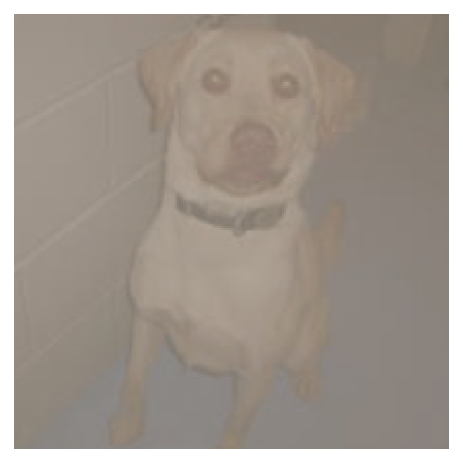

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import matplotlib.pyplot as plt

images, labels = next(iter(testloader))

images, labels = images.to(device), labels.to(device)

logps = model(images[0].view(1,*images[0].shape))
ps = torch.exp(logps)
top_p, top_class = ps.topk(k=1, dim=1)

helper.imshow(images[0].to('cpu'))
print("Label: ",labels[0])

print("Predicted CLass: ", top_class)